In [1]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# visualization
import matplotlib.pyplot as plt

In [2]:
data, labels, _ = utility.load_data()

Dataset split: 70700 train rows
Dataset split: 70700 test rows


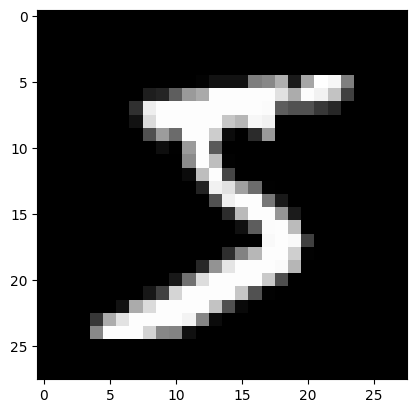

In [3]:
print(f"Dataset split: {len(data)} train rows")
print(f"Dataset split: {len(labels)} test rows")

point = data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [4]:
normal_train_data, anom_train_data, test_data, test_labels, val_data = utility.preprocess_data(data, labels)

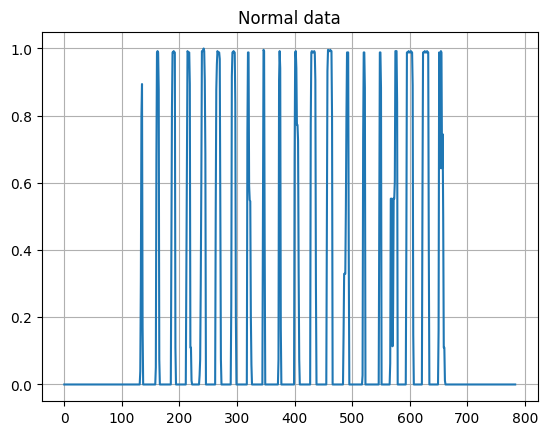

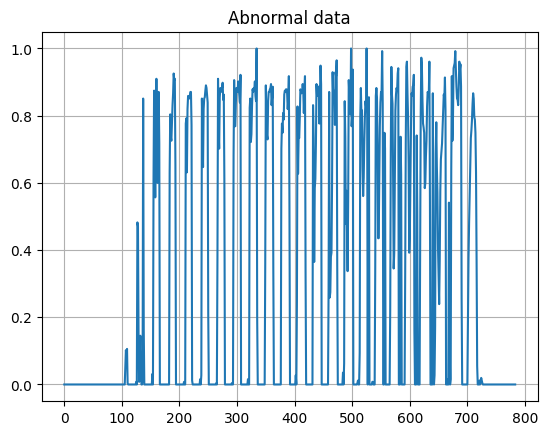

In [5]:
utility.plot_normalized_pixel_data(normal_train_data, anom_train_data)

In [6]:
# Input image
input_img = Input(shape=(784,))

In [7]:
# encoder
encoded = Dense(256, activation='relu')(input_img)
encoded = BatchNormalization()(encoded)
encoded = Dense(128, activation='relu', kernel_regularizer=L1L2(l1=1e-5, l2=1e-5))(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

In [8]:
# decoder
decoded = Dense(32, activation='relu', kernel_regularizer=L1L2(l1=1e-5, l2=1e-5))(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [9]:
autoencoder = Model(input_img, decoded)

In [10]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=100, batch_size=512, shuffle=True,
                          validation_data=(val_data, val_data), callbacks=[early_stopping])

Epoch 1/100
83/83 [==============================] - 2s 13ms/step - loss: 0.0960 - val_loss: 0.0764
Epoch 2/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0490 - val_loss: 0.0497
Epoch 3/100
83/83 [==============================] - 1s 12ms/step - loss: 0.0358 - val_loss: 0.0398
Epoch 4/100
83/83 [==============================] - 1s 12ms/step - loss: 0.0306 - val_loss: 0.0342
Epoch 5/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0278 - val_loss: 0.0315
Epoch 6/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0257 - val_loss: 0.0297
Epoch 7/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0247 - val_loss: 0.0256
Epoch 8/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0230 - val_loss: 0.0253
Epoch 9/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0222 - val_loss: 0.0237
Epoch 10/100
83/83 [==============================] - 1s 11ms/step - loss: 0.0211 - val_loss: 0.0228

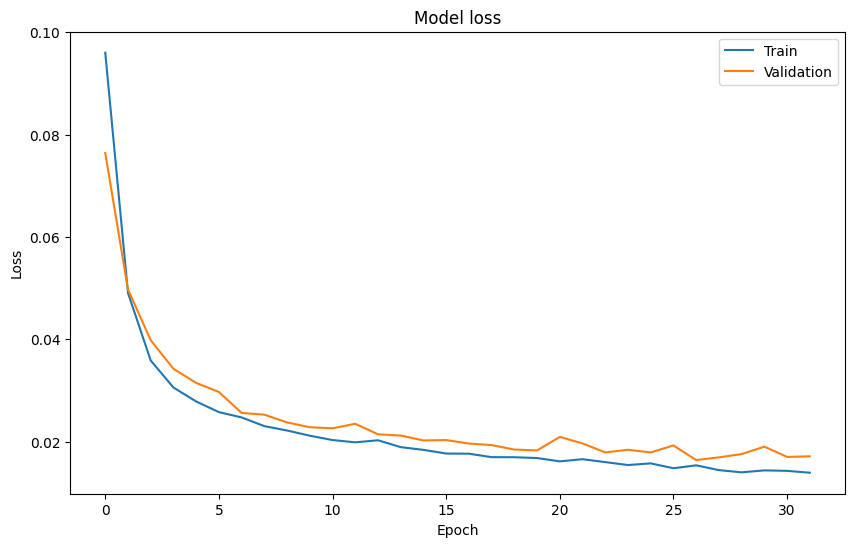

In [12]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1313/1313 [==============================] - 2s 1ms/step


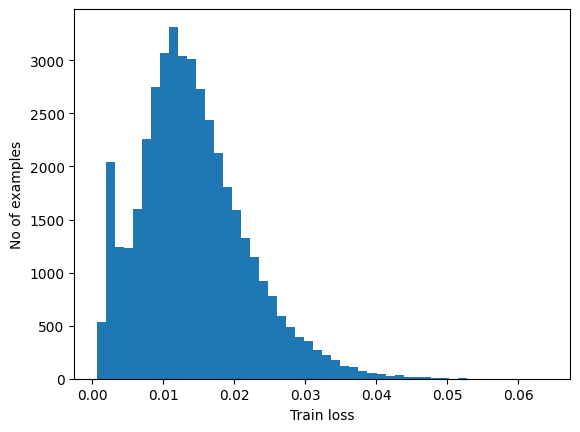

In [13]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [14]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold)

# Choose a quantile (e.g., 99th percentile) for the threshold
threshold = np.percentile(train_loss, 99)
print("Quantile Threshold ", threshold)

Threshold  0.021766374
Quantile Threshold  0.03615509819239378


14/14 [==============================] - 0s 2ms/step


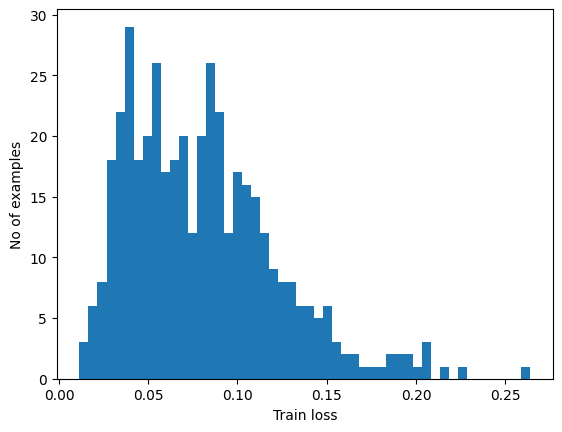

In [15]:
reconstructions = autoencoder.predict(anom_train_data)
train_loss = tf.keras.losses.mse(reconstructions, anom_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [16]:
threshold_anom = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold_anom)

Threshold  0.122271925


In [17]:
preds, loss, proba = utility.predict(autoencoder, test_data, threshold)

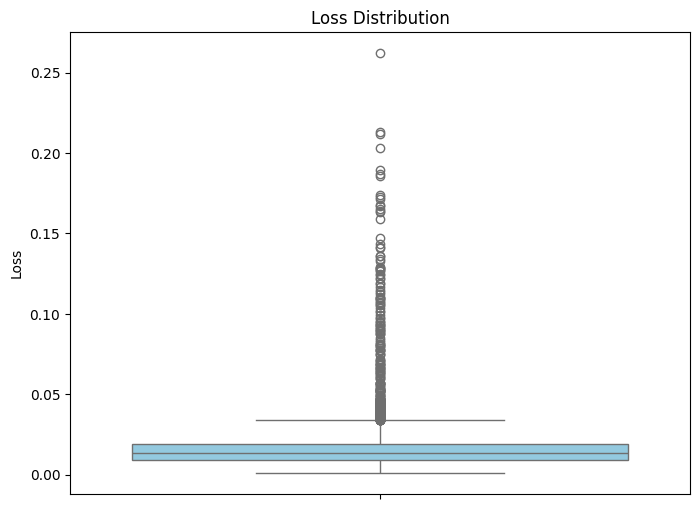

In [18]:
utility.boxplot_plot("Loss", loss)

C:\Users\zippe\AppData\Local\Temp\ipykernel_4964\1046356683.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')


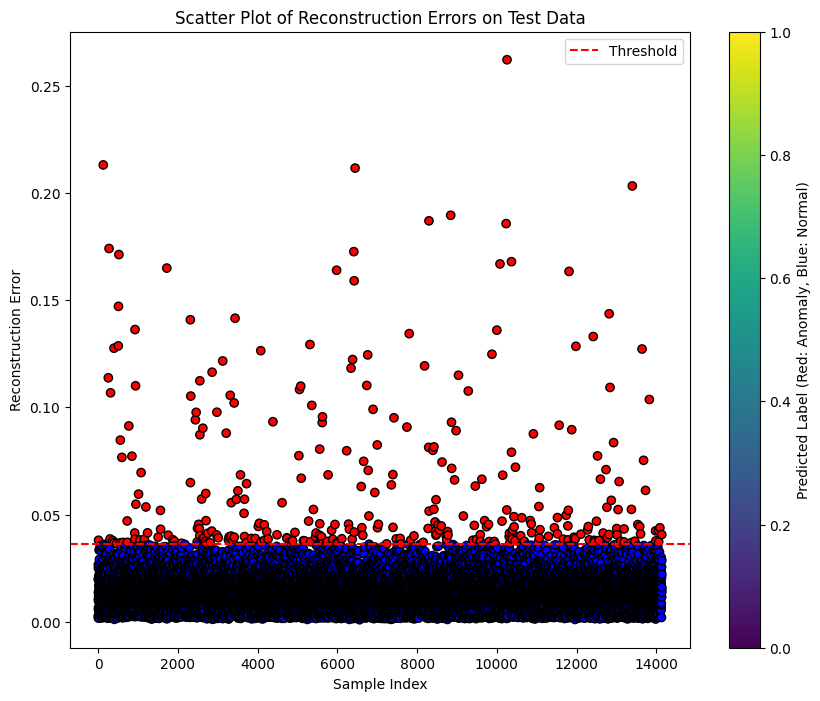

In [19]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(loss > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [20]:
a, p, r, report, cm = utility.get_metrics(preds, test_labels)

In [21]:
utility.print_stats(a, p, r, report, cm)

Accuracy = 0.9863507779349363
Precision = 0.998987781071506
Recall = 0.9872106316090311
Report
               precision    recall  f1-score   support

     anomaly       0.42      0.90      0.57       144
      normal       1.00      0.99      0.99     13996

    accuracy                           0.99     14140
   macro avg       0.71      0.94      0.78     14140
weighted avg       0.99      0.99      0.99     14140

Confusion Matrix
[[  130    14]
 [  179 13817]]


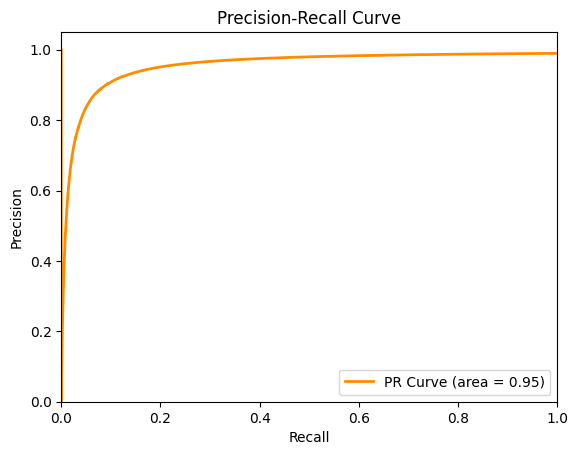

In [22]:
utility.pr_auc_plot(proba, test_labels)

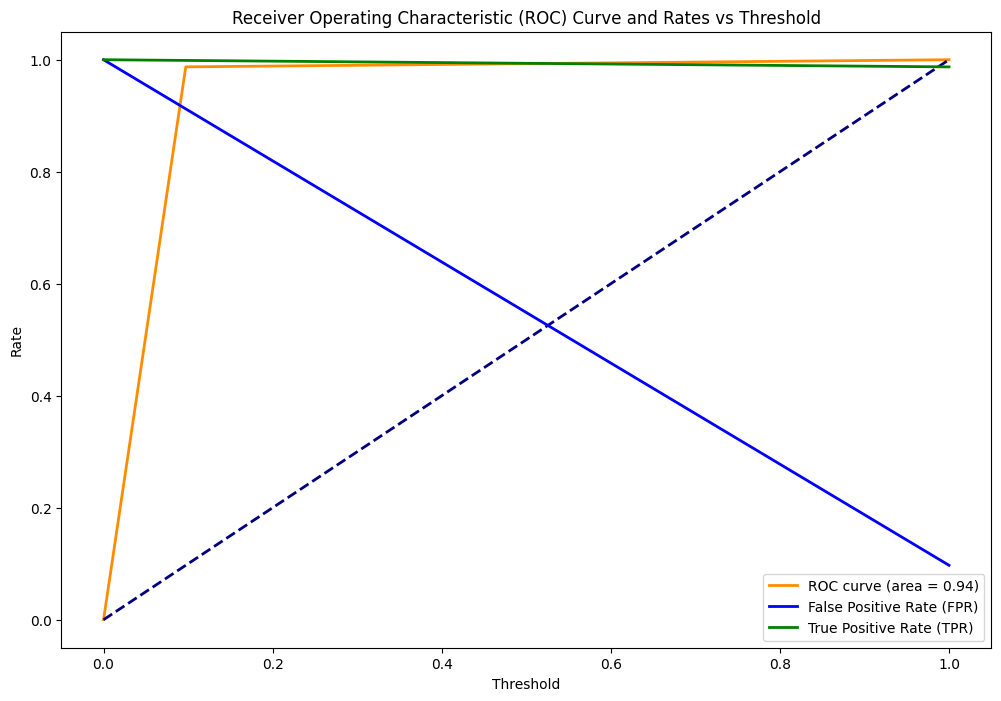

In [23]:
utility.roc_plot(preds, test_labels)

True Negatives: 130
False Positives: 14
False Negatives: 179
True Positives: 13817


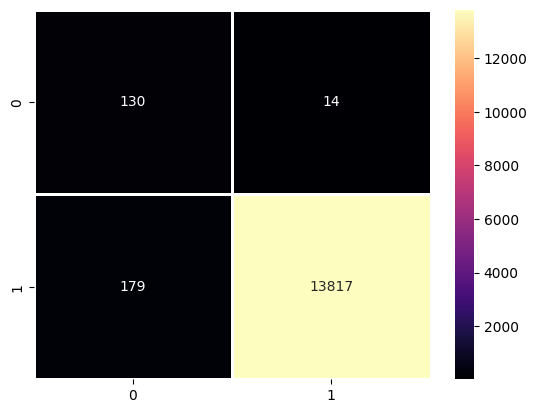

In [24]:
utility.create_heatmap(cm)

In [25]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


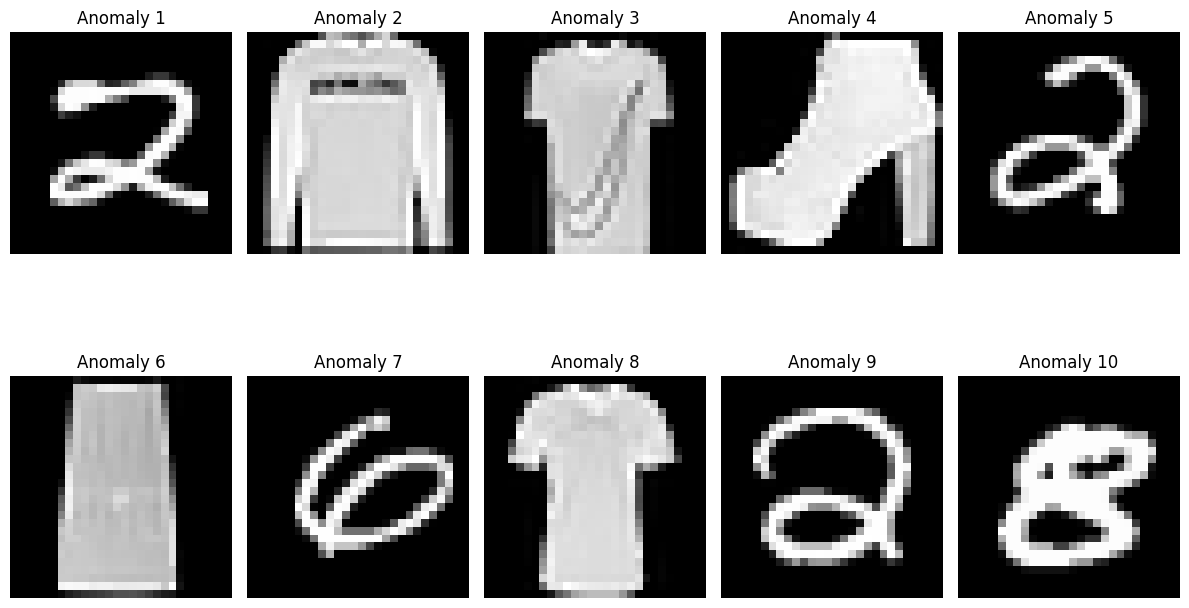

In [26]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data)